In [1]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
torch.random.manual_seed(73)
random.seed(73)

# load and preprocess dataset

In [2]:
cancer = pd.read_csv('https://github.com/YBIFoundation/Dataset/raw/main/Cancer.csv')
print(cancer.columns)
#print(cancer['diagnosis'][20])
#print(cancer['diagnosis'].values.tolist())
y = []
for i in cancer['diagnosis'].values.tolist():
    if i=='M':
        y.append([1.0])
    else:
        y.append([0.0])

x = cancer.drop(['id','diagnosis','Unnamed: 32', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],axis=1)

x = (x - x.mean()) / x.std()
'''
    x = torch.tensor(data.values).float()
    return split_train_test(x, y)
'''

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.8, random_state=252)

x_train = torch.tensor(pd.DataFrame(x_train).values, dtype=float)
x_test = torch.tensor(pd.DataFrame(x_test).values, dtype=float)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
#print(x_train.shape)
#print(y_train.shape)

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


# Training

In [3]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)

    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [5]:
n_features = x_train.shape[1]
#(n_features)
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

In [8]:
# define the number of epochs for both plain and encrypted training
EPOCHS = 3

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

#print(x_train.float().dtype)
t_start = time()
model = train(model, optim, criterion, x_train.float(), y_train.float())
t_end = time()
print(f"\nAverage time per epoch: {(t_end-t_start) / EPOCHS} seconds")

Loss at epoch 1: 0.610687792301178
Loss at epoch 2: 0.2748606204986572
Loss at epoch 3: 0.24337229132652283

Average time per epoch: 0.002000570297241211 seconds


In [9]:
def accuracy(model, x, y):
    out = model(x.float())
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Accuracy on plain test_set: 0.9561403393745422


# Encrypted Logistic Regression Model Training

### ENCRYPTED MODEL

In [10]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        #print("test: ", enc_x.shape)
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        # print(enc_x.shape)
        #　print(out_minus_y.shape)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # use a small regularization term to keep the output of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
    
    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])
    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        #print("x_test.matmul(w): ", x_test.float().matmul(w))
        out = torch.sigmoid(x_test.float().matmul(w.float()) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()    
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

### ENCRYPTED DATASET

In [11]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [12]:
t_start = time()
#print(x_train.shape)
#print(y_train.shape)
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
#print(enc_x_train[0].shape)
#print(enc_y_train[0].shape)
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 6 seconds


### DISTRIBUTION OBSERVATION OF DATASET

Distribution on plain data:


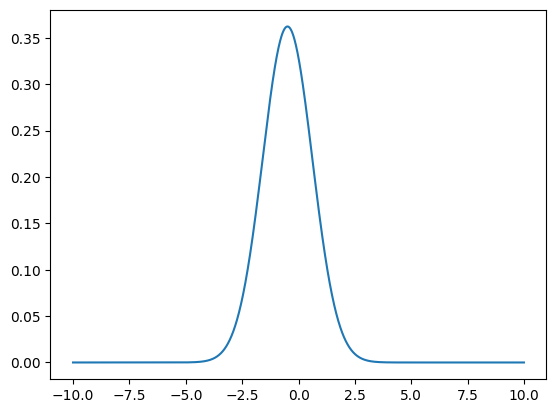

Distribution on encrypted data:


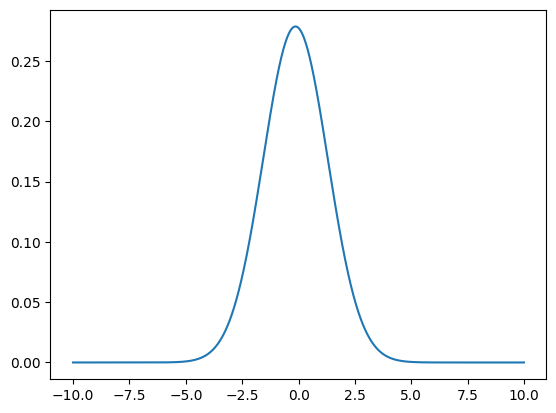

In [26]:
normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)
    
# plain distribution
lr = LR(n_features)
data = lr.lr(x_test.float())
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(lr)
eelr.encrypt(ctx_training)
encrypted_out_distribution(eelr, enc_x_train)

### ENCRYPTED MODEL TRAINING AND TESTING

In [17]:
eelr = EncryptedLR(LR(n_features))

times = []
for epoch in range(EPOCHS):
    eelr.encrypt(ctx_training)
    
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        #print(enc_x.shape)
        #print(enc_y.shape)
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    eelr.decrypt()
    
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"\nAverage time per epoch: {(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")


Average time per epoch: 38.534266233444214 seconds
Final accuracy is 0.9210526347160339
Difference between plain and encrypted accuracies: 0.0350877046585083
